In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp
import sorf_lib as sf

In [3]:
sns.set_context('talk')
sns.set_style('white')


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [4]:
oorder = ['Intergenic', 'Antisense', 'Out of Frame','In Frame',  'Annotated', ]
opalette = sns.color_palette("rainbow", 5).as_hex()
#del opalette[4]
soorder = [oorder[0], oorder[4]]
sopalette = [opalette[0], opalette[4]]
sopaletted = ['#04347b','#802800']

In [5]:
dpath = 'orffinder_tmp'
summary_suffix = '.sorf.summary.csv.gz'
sorf_result_suffix = '.sorf.feather.gz'

In [6]:
ccrg_excel_fname =  'ccrg and procm genes.xlsx'

In [7]:
# david's reanalysis file
protein_fname = r'Seq46351_report.xlsx'
protein_dpath = os.path.join('1A3','proteomics', 'Davids reanalysis')
protein_fpath = os.path.join(protein_dpath, protein_fname)

In [8]:
genome = 'MIT9313'

In [9]:
genome_df = pd.read_feather(os.path.join('data', f'{genome}.ncbi.gb.feather.gz'))


C:\Users\wosnat\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [10]:
ccrg_procm_df = pd.read_excel(os.path.join('data', ccrg_excel_fname), sheet_name='data')
ccrg_procm_df2 = pd.read_excel(os.path.join('data', ccrg_excel_fname), sheet_name='proc')

In [11]:
genome_df.head()

,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,function,genome,old_locus_tag,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence
0,MIT9313,AKG35_RS00005,"PMT0001,PMT_0001",CDS,AKG35_RS00005,+,173,1340,173,1340,DNA polymerase III subunit beta,MIT9313,"PMT0001,PMT_0001,RG24_RS00005",DNA polymerase III subunit beta,,WP_011129380.1,,,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...
1,MIT9313,AKG35_RS00010,"PMT0002,PMT_0002",CDS,AKG35_RS00010,+,1343,2120,1343,2120,hypothetical protein,MIT9313,"PMT0002,PMT_0002,RG24_RS00010",hypothetical protein,,WP_041384224.1,,,MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...
2,MIT9313,AKG35_RS00015,"PMT0003,PMT_0003",CDS,AKG35_RS00015,+,2177,4562,2177,4562,phosphoribosylformylglycinamidine synthase sub...,MIT9313,"PMT0003,PMT_0003,RG24_RS00015",phosphoribosylformylglycinamidine synthase sub...,,WP_011129382.1,,,MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...
3,MIT9313,AKG35_RS00020,"PMT0004,PMT_0004",CDS,AKG35_RS00020,+,4621,6079,4621,6079,amidophosphoribosyltransferase,MIT9313,"PMT0004,PMT_0004,RG24_RS00020",amidophosphoribosyltransferase,,WP_011129383.1,,,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...
4,MIT9313,AKG35_RS00025,"PMT0005,PMT_0005",CDS,AKG35_RS00025,-,6114,8604,6114,8604,DNA topoisomerase 4 subunit A,MIT9313,"PMT0005,PMT_0005,RG24_RS00025",DNA topoisomerase 4 subunit A,,WP_011129384.1,,,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...


In [12]:
genome_df = pd.merge(genome_df, ccrg_procm_df, left_on='pmt_id', right_on='Gene', how='left' )

In [13]:
genome_df.loc[genome_df['product'].str.contains('CCRG-2'), 'family'] = 'CCRG-2'

In [14]:
genome_df.loc[genome_df['function'].isin(['Nif11-like leader peptide family natural product precursor', 
                                          'lantipeptide']),
              'family'
             ] = 'ProcA'

In [15]:
genome_df.loc[genome_df['family'] == 'CCRG-1', 'function'].unique()

array([], dtype=object)

In [16]:
ccrg_procm_df.family.value_counts()

ProcA              29
CCRG-2             12
CCRG-1              3
procM               1
ABC transporter     1
Name: family, dtype: int64

In [17]:
genome_df.family.value_counts()

ProcA     35
CCRG-2    15
Name: family, dtype: int64

In [18]:
def find_in_genome(x):
    found = genome_df.loc[(genome_df.left >= x.left-10) & (genome_df.right <= x.right + 10)]
    return found['family'].unique()
ccrg_procm_df2.loc[~ccrg_procm_df2.pmt.isin(genome_df.pmt_id)].apply(find_in_genome, axis=1)


0       [nan]
1     [ProcA]
2     [ProcA]
3     [ProcA]
4     [ProcA]
5     [ProcA]
6     [ProcA]
7     [ProcA]
8     [ProcA]
9     [ProcA]
10    [ProcA]
11    [ProcA]
12    [ProcA]
13    [ProcA]
14    [ProcA]
15    [ProcA]
16    [ProcA]
17    [ProcA]
18    [ProcA]
19    [ProcA]
20    [ProcA]
21    [ProcA]
22    [ProcA]
23    [ProcA]
24    [ProcA]
25    [ProcA]
26    [ProcA]
27    [ProcA]
28    [ProcA]
29    [ProcA]
30      [nan]
dtype: object

In [19]:
ccrg_procm_df.loc[~ccrg_procm_df.Gene.isin(genome_df.pmt_id) & ccrg_procm_df.family.isin(['CCRG-1', 'CCRG-2'])]

,family,Gene
0,CCRG-1,PMT0956
1,CCRG-1,PMT0971
2,CCRG-1,PMT0885
3,CCRG-2,PMT0923
4,CCRG-2,PMT0928
5,CCRG-2,PMT0925
6,CCRG-2,PMT2125
7,CCRG-2,P9313_26651
8,CCRG-2,PMT0238
9,CCRG-2,P9313_26661


In [20]:
# ProcAs.2	s	2	NP_894719	33863159	969887	970183	+	PMT0887	567999
# ProcAs.1	s	1	NP_895437	33863877	1710816	1711142	+	PMT1610	568734
# ProcA4.4	4	4	NP_894754	33863194	1004342	1004653	-	PMT0922	568035
# CCRG1: PMT0971 1049007	1049402
# CCRG1: PMT0885 968520	968768
# CCRG2 1005678	1005340	-	PMT0923
# CCRG2 1010507	1010169	-	PMT0928
# CCRG2 2238151	2237804	-	PMT2125


genome_df.loc[(genome_df.start >= 1049000) & (genome_df.stop <= 1049402), 'family'] = 'CCRG-1'
genome_df.loc[(genome_df.start >= 968510) & (genome_df.stop <= 968780), 'family'] = 'CCRG-1'
genome_df.loc[(genome_df.start >= 1005320) & (genome_df.stop <= 1005700), 'family'] = 'CCRG-2'
genome_df.loc[(genome_df.start >= 1010150) & (genome_df.stop <= 1010520), 'family'] = 'CCRG-2'
genome_df.loc[(genome_df.start >= 2237800) & (genome_df.stop <= 2238160), 'family'] = 'CCRG-2'


In [21]:
genome_df.groupby(['family', 'function'])['contig_id', 'Gene'].count()

contig_id  Gene
family function                                                           
CCRG-1 guanylate-binding protein                                   1     0
       hypothetical protein                                        1     0
CCRG-2 CCRG-2 family RiPP                                         12     0
       CCRG-2 family protein                                       3     0
       hypothetical protein                                        3     0
ProcA  Nif11-like leader peptide family natural produc...         34     0
       lantipeptide                                                1     0

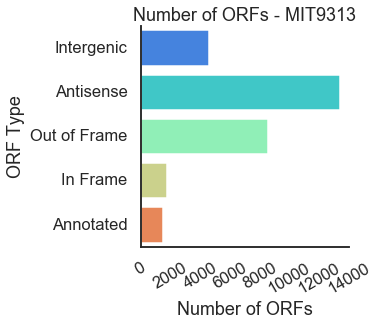

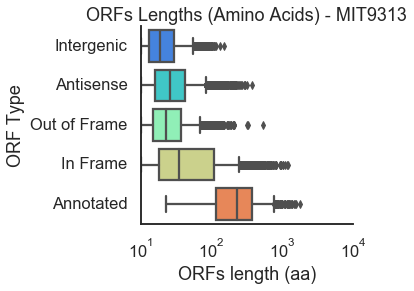

In [22]:
omap = {'standalone' : 'Intergenic', 
        'out_frame' : 'Out of Frame', 
        'antisense' : 'Antisense', 
        'in_frame' :'In Frame', 
        'known' : 'Annotated'}

genome = 'MIT9313'
df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.ncbi.sorf.feather.gz'))
df = df.loc[df.otype != 'overlap']
df.otype = df.otype.map(omap)
    
sns.catplot(data=df, y='otype', kind='count', aspect=1.4, height=4,
       order=oorder, palette=opalette
           )
plt.xticks(rotation=30) 
plt.ylabel('ORF Type')
plt.xlabel('Number of ORFs')
plt.title(f'Number of ORFs - {genome}')

sns.catplot(data=df, y='otype', x='len_aa', aspect=1.4, height=4,
        kind='box',
       order=oorder, palette=opalette
           )
plt.xscale('log')
plt.ylabel('ORF Type')
plt.xlabel('ORFs length (aa)')

plt.title(f'ORFs Lengths (Amino Acids) - {genome}')
plt.show()
    

In [23]:
genome_df['aa_len'] = genome_df.aa_sequence.str.len()
genome_df['short'] = genome_df['aa_len'] <= 100

In [24]:
genome_df.groupby('type').genome.count()

type
CDS           2403
ncRNA            3
rRNA             6
regulatory       2
tRNA            44
tmRNA            1
Name: genome, dtype: int64

In [25]:
(genome_df.loc[~genome_df['type'].isin(['CDS']),'aa_sequence'] != '').sum()

0

In [26]:
genome_df.groupby(['type', 'short']).genome.count()

type        short
CDS         False    1855
            True      548
ncRNA       True        3
rRNA        True        6
regulatory  True        2
tRNA        True       44
tmRNA       True        1
Name: genome, dtype: int64

In [27]:
genome_df.head()

,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,...,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence,family,Gene,aa_len,short
0,MIT9313,AKG35_RS00005,"PMT0001,PMT_0001",CDS,AKG35_RS00005,+,173,1340,173,1340,...,DNA polymerase III subunit beta,,WP_011129380.1,,,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...,NaN,NaN,388,False
1,MIT9313,AKG35_RS00010,"PMT0002,PMT_0002",CDS,AKG35_RS00010,+,1343,2120,1343,2120,...,hypothetical protein,,WP_041384224.1,,,MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...,NaN,NaN,258,False
2,MIT9313,AKG35_RS00015,"PMT0003,PMT_0003",CDS,AKG35_RS00015,+,2177,4562,2177,4562,...,phosphoribosylformylglycinamidine synthase sub...,,WP_011129382.1,,,MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...,NaN,NaN,794,False
3,MIT9313,AKG35_RS00020,"PMT0004,PMT_0004",CDS,AKG35_RS00020,+,4621,6079,4621,6079,...,amidophosphoribosyltransferase,,WP_011129383.1,,,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...,NaN,NaN,485,False
4,MIT9313,AKG35_RS00025,"PMT0005,PMT_0005",CDS,AKG35_RS00025,-,6114,8604,6114,8604,...,DNA topoisomerase 4 subunit A,,WP_011129384.1,,,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...,NaN,NaN,829,False


In [28]:
df.loc[:,'merge_location'] = df['location']
df.loc[df['location'].isna(), 'merge_location'] = df.loc[df['location'].isna(), 'overlap_location']
df1 = pd.merge(df, genome_df, how='left', left_on='merge_location', right_on='location', suffixes=['', '_overlap'])

In [29]:
protein_df = pd.read_excel(protein_fpath)

In [30]:
protein_df.Description.head()[0]

'>lcl|ORF9138_BX548175.1:1942594:1942632 unnamed protein product'

In [31]:
protein_df['orfid'] = protein_df['Description'].str.replace(r' unnamed protein product', '').str.replace(r'>lcl\|','')


In [32]:
protein_df.orfid[0]

'ORF9138_BX548175.1:1942594:1942632'

In [33]:
df1.orfid[0]

'ORF1_BX548175.1:78:176'

In [34]:
protein_df.columns

Index(['Description', '|Log Prob|', 'Best\n|Log Prob|', 'Best\nscore',
       'Total\nIntensity', '# of\nspectra', '# of\nunique peptides',
       '# of mod\npeptides', 'Coverage\n%', '# AA's in\nprotein', 'orfid'],
      dtype='object')

In [35]:
additional_annotated_df = protein_df.loc[protein_df.Description.str.startswith('>AK')]
additional_annotated_df.rename(columns={
    '|Log Prob|': 'log_prob', 
    'Best\n|Log Prob|' : 'best log prob',
    'Best\nscore': 'best_score', 
    'Total\nIntensity' : 'total_intensity', 
    '# of\nspectra' : 'num_spectra',
    '# of\nunique peptides'  :'Unique Peptides', 
    '# of mod\npeptides' : 'mod_peptides',
    'Coverage\n%' : 'Coverage',
    "# AA's in\nprotein" : 'AAs',
}, inplace=True)
additional_annotated_df['short'] = additional_annotated_df['AAs'] < 100
additional_annotated_df['ms_detected'] = (additional_annotated_df['Unique Peptides'] > 1) | (additional_annotated_df['best_score'] > 500)


C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [36]:
additional_annotated_df[['orfid', 'product']] = additional_annotated_df.Description.str.replace('^>','').str.split(' ', expand=True, n=1)

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\frame.py:3489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [37]:
additional_annotated_df = pd.merge(additional_annotated_df, genome_df, left_on='orfid', right_on='location', how='left', 
                                   suffixes=['', '_y'])

In [38]:
additional_annotated_df.loc[additional_annotated_df.short & additional_annotated_df.ms_detected
                           ].to_pickle('found_sorf_additional_ISME16.pkl.gz')

In [39]:
additional_annotated_df['contig'] = 'genome'
additional_annotated_df['aaseq'] = additional_annotated_df['aa_sequence']
additional_annotated_df['otype'] = 'Annotated'
additional_annotated_df['len_aa'] = additional_annotated_df.AAs

In [40]:
merge_df = pd.merge(df1, protein_df, how='left', on='orfid', suffixes=['','_p'])

In [41]:
merge_df.columns

Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'location', 'type', 'start_r', 'stop_r', 'function',
       'figfam', 'nucleotide_sequence', 'aa_sequence', 'genome', 'left_r',
       'right_r', 'overlap_location', 'overlap_strand', 'overlap_gene_type',
       'overlap_count', 'is_same_strand', 'is_out_of_frame', 'is_inside',
       'is_upstream', 'is_downstream', 'overlap_type', 'otype',
       'merge_location', 'contig_id_overlap', 'gene_id_overlap', 'pmt_id',
       'type_overlap', 'location_overlap', 'strand_overlap', 'start_overlap',
       'stop_overlap', 'left_overlap', 'right_overlap', 'function_overlap',
       'genome_overlap', 'old_locus_tag', 'product', 'db_xref', 'protein_id',
       'figfam_overlap', 'nucleotide_sequence_overlap', 'aa_sequence_overlap',
       'family', 'Gene', 'aa_len', 'short', 'Description', '|Log Prob|',
       'Best\n|Log Prob

In [42]:
merge_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,Description,|Log Prob|,Best\n|Log Prob|,Best\nscore,Total\nIntensity,# of\nspectra,# of\nunique peptides,# of mod\npeptides,Coverage\n%,# AA's in\nprotein
0,ORF1_BX548175.1:78:176,BX548175.1,78,176,78,176,+,MNENDLPLHFLLACEILGDLFSVLVLVVTLIQ,99,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ORF2_BX548175.1:453:590,BX548175.1,453,590,453,590,+,MRLVNRLNSKVQAGVIRCVGCLLMIFLNYLLLKVVRLSRLMRGLF,138,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ORF3_BX548175.1:669:722,BX548175.1,669,722,669,722,+,MVKPWKQRQLMVTALPF,54,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ORF4_BX548175.1:972:1025,BX548175.1,972,1025,972,1025,+,MVLLGVSMLIGVLLLQL,54,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ORF5_BX548175.1:1167:1205,BX548175.1,1167,1205,1167,1205,+,MLFRLLLMFVMY,39,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
merge_df.rename(columns={
    '|Log Prob|': 'log_prob', 
    'Best\n|Log Prob|' : 'best log prob',
    'Best\nscore': 'best_score', 
    'Total\nIntensity' : 'total_intensity', 
    '# of\nspectra' : 'num_spectra',
    '# of\nunique peptides'  :'Unique Peptides', 
    '# of mod\npeptides' : 'mod_peptides',
    'Coverage\n%' : 'Coverage',
    "# AA's in\nprotein" : 'AAs',
}, inplace=True)

In [44]:
merge_df = pd.concat([merge_df, additional_annotated_df])

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [45]:
merge_df.isna().sum()

AAs                33489
Coverage           33489
Description        33489
Gene               34916
Unique Peptides    33489
                   ...  
strand                 0
strand_overlap       447
total_intensity    33489
type               32993
type_overlap         447
Length: 74, dtype: int64

In [46]:
merge_df['short'] = merge_df.len_aa < 100

In [47]:
(~merge_df.isna()).sum()

AAs                 1427
Coverage            1427
Description         1427
Gene                   0
Unique Peptides     1427
                   ...  
strand             34916
strand_overlap     34469
total_intensity     1427
type                1923
type_overlap       34469
Length: 74, dtype: int64

In [48]:
protein_df.shape

(1416, 11)

In [49]:
merge_df.columns[~merge_df.columns.isin(additional_annotated_df.columns)]

Index(['aa_sequence_overlap', 'contig_id_overlap', 'figfam_overlap',
       'function_overlap', 'gene_id_overlap', 'genome_overlap',
       'is_downstream', 'is_inside', 'is_out_of_frame', 'is_same_strand',
       'is_upstream', 'left_overlap', 'left_r', 'len_aa3', 'len_nn',
       'location_overlap', 'merge_location', 'nucleotide_sequence_overlap',
       'overlap_count', 'overlap_gene_type', 'overlap_location',
       'overlap_strand', 'overlap_type', 'rast_left', 'rast_right',
       'right_overlap', 'right_r', 'start_overlap', 'start_r', 'stop_overlap',
       'stop_r', 'strand_overlap', 'type_overlap'],
      dtype='object')

In [50]:
merge_df['Unique Peptides'] = pd.to_numeric(merge_df['Unique Peptides'])
merge_df['Coverage'] = pd.to_numeric(merge_df['Coverage'])
merge_df['best_score'] = pd.to_numeric(merge_df['best_score'])


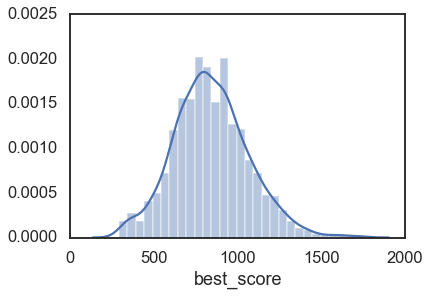

In [51]:
sns.distplot(merge_df.best_score.dropna())

C:\Users\wosnat\Anaconda3\lib\site-packages\seaborn\categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


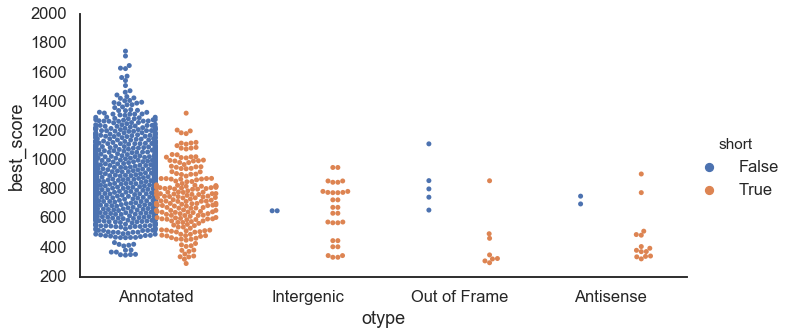

In [52]:
sns.catplot(data=merge_df.dropna(subset=['best_score']), x='otype', y='best_score', aspect=2, 
            kind='swarm', hue='short', split=True)

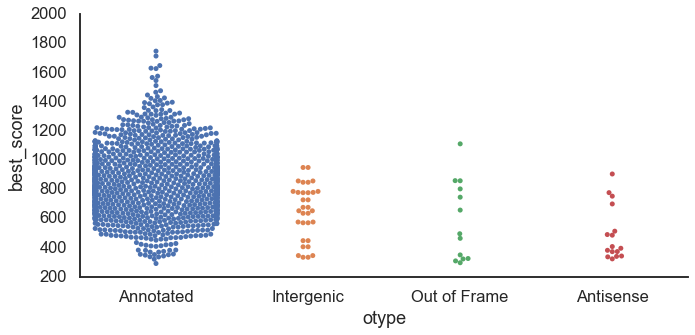

In [53]:
sns.catplot(data=merge_df.dropna(subset=['best_score']), x='otype', y='best_score', aspect=2, 
            kind='swarm', #hue='short', split=True
           )

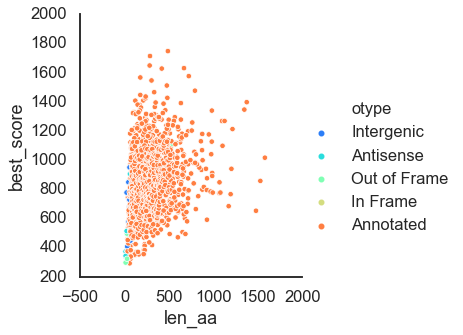

In [54]:
sns.relplot(data=merge_df, y='best_score', x='len_aa', hue='otype', s=30, hue_order=oorder, palette=opalette)

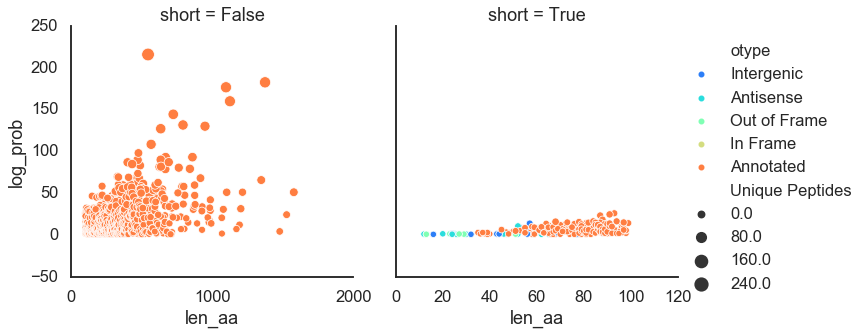

In [55]:
sns.set_context('talk')
g = sns.relplot(data=merge_df, y='log_prob', x='len_aa', hue='otype',  hue_order=oorder, 
            palette=opalette, col='short',
            size='Unique Peptides',# s=30,
           facet_kws=dict(#sharey=False, 
               sharex=False)
           )
g.axes.flat[0].set_xticks([0,1000,2000]) # set new labels

In [56]:
merge_df['multiple unique peptides'] = merge_df['Unique Peptides'] > 1
merge_df['has unique peptides'] = merge_df['Unique Peptides'] > 0
merge_df['ms_detected'] = (merge_df['Unique Peptides'] > 1) | (merge_df['best_score'] > 500)

In [57]:
merge_df.shape

(34916, 76)

In [58]:
merge_df.columns

Index(['AAs', 'Coverage', 'Description', 'Gene', 'Unique Peptides', 'aa_len',
       'aa_sequence', 'aa_sequence_overlap', 'aaseq', 'best log prob',
       'best_score', 'contig', 'contig_id', 'contig_id_overlap', 'db_xref',
       'family', 'figfam', 'figfam_overlap', 'function', 'function_overlap',
       'gene_id', 'gene_id_overlap', 'genome', 'genome_overlap',
       'is_downstream', 'is_inside', 'is_out_of_frame', 'is_same_strand',
       'is_upstream', 'left', 'left_overlap', 'left_r', 'len_aa', 'len_aa3',
       'len_nn', 'location', 'location_overlap', 'log_prob', 'merge_location',
       'mod_peptides', 'ms_detected', 'nucleotide_sequence',
       'nucleotide_sequence_overlap', 'num_spectra', 'old_locus_tag', 'orfid',
       'otype', 'overlap_count', 'overlap_gene_type', 'overlap_location',
       'overlap_strand', 'overlap_type', 'pmt_id', 'product', 'product_y',
       'protein_id', 'rast_left', 'rast_right', 'right', 'right_overlap',
       'right_r', 'short', 'short_y', 's

In [59]:
genome_df.type.value_counts()

CDS           2403
tRNA            44
rRNA             6
ncRNA            3
regulatory       2
tmRNA            1
Name: type, dtype: int64

In [60]:
merge_df['otype'].value_counts()

Antisense       13432
Intergenic       9254
Out of Frame     8544
Annotated        1923
In Frame         1763
Name: otype, dtype: int64

In [61]:
merge_df['ms_detected'].value_counts()

False    33519
True      1397
Name: ms_detected, dtype: int64

In [62]:
merge_df = merge_df.drop_duplicates(['orfid', 'otype', 'ms_detected', 'short', ])

In [63]:
merge_df.groupby(['otype', 'ms_detected', 'short', ])['len_aa'].count()

otype         ms_detected  short
Annotated     False        False      399
                           True       166
              True         False     1163
                           True       195
Antisense     False        False      425
                           True     13000
              True         False        2
                           True         5
In Frame      False        False      475
                           True      1288
Intergenic    False        False       11
                           True      4603
              True         False        1
                           True        12
Out of Frame  False        False       96
                           True      8442
              True         False        5
                           True         1
Name: len_aa, dtype: int64

In [64]:
merge_df.pivot_table(index=['otype'], columns=['short', 'ms_detected', ], values=['orfid'], aggfunc='count')

orfid                        
short         False            True        
ms_detected   False   True     False  True 
otype                                      
Annotated     399.0  1163.0    166.0  195.0
Antisense     425.0     2.0  13000.0    5.0
In Frame      475.0     NaN   1288.0    NaN
Intergenic     11.0     1.0   4603.0   12.0
Out of Frame   96.0     5.0   8442.0    1.0

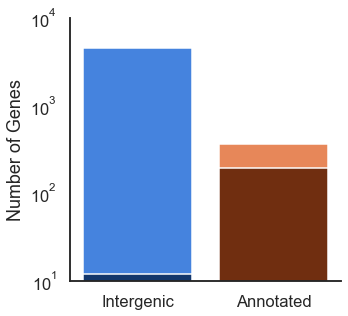

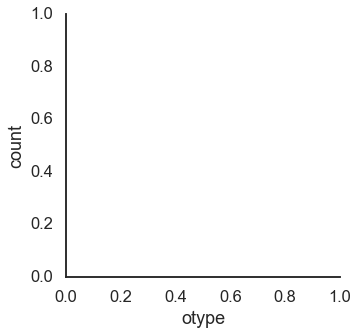

In [65]:
sopaletted = ['#04347b','#802800']
g = sns.catplot(data=merge_df.loc[merge_df.otype.isin(['Intergenic', 'Annotated']) & 
                                  merge_df.short].drop_duplicates(['orfid', 'short', 'ms_detected']),
                #              hue='ms_detected',
                order=soorder, palette=sopalette,
                kind='count', x='otype')
sns.catplot(data=merge_df.loc[merge_df.otype.isin(['Intergenic', 'Annotated']) & 
                                  merge_df.short & merge_df.ms_detected].drop_duplicates(['orfid', 'short', 'ms_detected']),
                              #hue='ms_detected', 
                kind='count', x='otype',
                ax=g.ax,
                order=soorder, palette=sopaletted,
            
                
               )
g.set(yscale='log', xlabel='', ylabel='Number of Genes')
plt.show()

([], <a list of 0 Text yticklabel objects>)

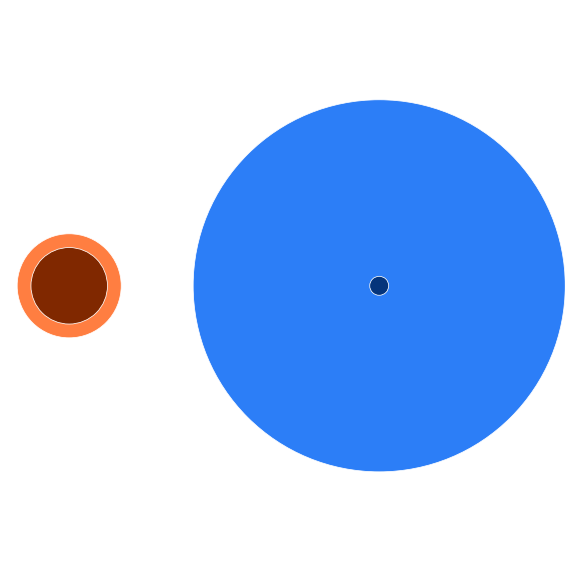

In [66]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10,10))

sopaletted = ['#04347b','#802800']
t_all_df = merge_df.loc[merge_df.otype.isin(['Intergenic', 'Annotated']) & 
              merge_df.short].drop_duplicates(
    ['orfid', 'short', 'ms_detected'
    ]).groupby(['otype'])['orfid'].count()
t_det_df = merge_df.loc[merge_df.otype.isin(['Intergenic', 'Annotated']) & 
               merge_df.ms_detected & merge_df.short].drop_duplicates(
    ['orfid', 'short', 'ms_detected'
    ]).groupby(['otype'])['orfid'].count()

t_all_df, t_det_df
ax = sns.scatterplot(x=[1,2], y=[1,1], size=[1,2], legend=False,
                hue=[2,1], 
                size_norm=None,
                     
                size_order=t_all_df, palette=sopalette, sizes=30*t_all_df)
sns.scatterplot(x=[1,2], y=[1,1], size=[1,2], legend=False, hue=[2,1], 
                size_norm=None,
                size_order=t_det_df,  palette=sopaletted, sizes=30*t_det_df)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.xticks([])
plt.yticks([])
#for x, point in zip([1,2], t_all_df.values):
#    plt.annotate(s=point, xy=(x-0.1,0.7))
    #ax.text(x, 0.5, point)

putative ORFs
Annotated
MS Detected
SEP MS Detected
Novel SEP MS Detected
[4615, 1923, 1371, 207, 12]


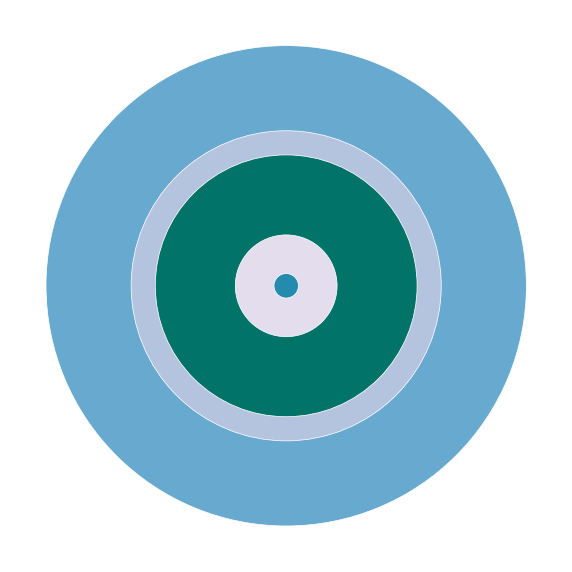

In [72]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10,10))

sopaletted = ['#04347b','#802800']
t_sep_all_df = merge_df.loc[merge_df.otype.isin(['Intergenic', 'Annotated']) & 
              merge_df.short].drop_duplicates(
    ['orfid', 'short', 'ms_detected'
    ]).groupby(['otype'])['orfid'].count()
t_sep_det_df = merge_df.loc[merge_df.otype.isin(['Intergenic', 'Annotated']) & 
               merge_df.ms_detected & merge_df.short].drop_duplicates(
    ['orfid', 'short', 'ms_detected'
    ]).groupby(['otype'])['orfid'].count()
t_all_df = merge_df.loc[merge_df.otype.isin(['Intergenic', 'Annotated'])].drop_duplicates(
    ['orfid', 'short', 'ms_detected'
    ]).groupby(['otype'])['orfid'].count()
t_det_df= merge_df.loc[merge_df.otype.isin(['Intergenic', 'Annotated']) & merge_df.ms_detected].drop_duplicates(
    ['orfid', 'short', 'ms_detected'
    ]).groupby(['otype'])['orfid'].count()


# 10^4 Putative smORFs
#10^3 detected protein products
#10^2 small protein products 
#10^1 new intergenic small protein products

t_all_df, t_det_df

labels=['10^4 Putative smORFs',
'10^3 detected protein products',
'10^2 small protein products',
'10^1 new intergenic small protein products',
]


labels=['putative ORFs', 'Annotated', 'MS Detected', 'SEP MS Detected', 'Novel SEP MS Detected']
data= [t_sep_all_df['Intergenic'], t_all_df['Annotated'], t_det_df['Intergenic']+t_det_df['Annotated'], 
       t_sep_det_df['Intergenic']+t_sep_det_df['Annotated'], t_sep_det_df['Intergenic']]
N = len(data)

base_pal = sns.color_palette('PuBuGn_r', N).as_hex()

pal = [base_pal[2], base_pal[3], base_pal[0], base_pal[4], base_pal[1]]


ax = sns.scatterplot(x=[1]*N, y=[1]*N, size=range(N), legend=False,
                hue=range(N), 
                #size_norm=None,
                     
                #size_order=t_all_df,
                     palette=pal, 
                     sizes=[50*d for d in data])
sns.despine(top=True, right=True, left=True, bottom=True)
plt.xticks([])
plt.yticks([])
#for x, point in zip([1,2], t_all_df.values):
#    plt.annotate(s=point, xy=(x-0.1,0.7))
    #ax.text(x, 0.5, point)
t_all_df['Annotated']
print('\n'.join(labels))
print(data)
#print('\n'.join(labels))


In [ ]:
sns.color_palette('PuBuGn_r', N).as_hex()


In [ ]:
sns.palplot(sns.color_palette('PuBuGn', N))


In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
t= merge_df.loc[merge_df.otype.isin(['Intergenic', 'Annotated']) & merge_df.ms_detected].drop_duplicates(
    ['orfid', 'short', 'ms_detected'
    ]).groupby(['otype'])['orfid'].count()
sns.barplot(y=t.index, x=t, palette=sopalette, order=soorder)
plt.xscale('log')
plt.xlim(1,1e4)
sns.despine()
plt.xlabel('Detected Protein Products')
plt.ylabel('')
plt.yticks([])
t


In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
t= merge_df.loc[merge_df.otype.isin(['Intergenic', 'Annotated']) & merge_df.ms_detected & merge_df.short
               ].drop_duplicates(
    ['orfid', 'short', 'ms_detected'
    ]).groupby(['otype'])['orfid'].count()
sns.barplot(y=t.index, x=t, palette=sopalette, order=soorder)
plt.xscale('log')
plt.xlim(1,1e4)
sns.despine()
plt.xlabel('Detected SEP Protein Products')
plt.ylabel('')
plt.yticks([])

t


In [ ]:
t_all_df, t_det_df


In [ ]:
from matplotlib_venn import venn3
fig, ax = plt.subplots(figsize=(20,10))

# venn diagram
venn3(
    [
    set(merge_df.loc[merge_df.otype.isin(['Intergenic']) , 'orfid']),
    set(merge_df.loc[merge_df.otype.isin(['Intergenic']) & merge_df.ms_detected, 'orfid']),
    set(merge_df.loc[merge_df.otype.isin(['Intergenic']) & merge_df.short, 'orfid']),
    #set(merge_df.loc[merge_df.otype.isin(['Intergenic']) & ~merge_df.short, 'orfid']),
    ],
    ('intergenic', 'detected', 'SEP')
    
)

In [ ]:
from matplotlib_venn import venn3
fig, ax = plt.subplots(figsize=(20,10))

# venn diagram
venn3(
    [set(merge_df.loc[merge_df.otype.isin(['Annotated']) & merge_df.short, 'orfid']),
    set(merge_df.loc[merge_df.otype.isin(['Annotated']) & ~merge_df.short, 'orfid']),
    set(merge_df.loc[merge_df.otype.isin(['Annotated']) & ~merge_df.ms_detected, 'orfid']),
    ],
    ('<100aa', '>100aa', 'detected')
    
)

In [ ]:
sns.catplot(data=merge_df.loc[merge_df.short], x='otype', y='Unique Peptides', aspect=3, kind='swarm', order=oorder, palette=opalette,
           )


In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          'In Frame', #'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['short'] & merge_df.otype.isin([i])
                         & (~merge_df.best_score.isna()), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(0,2500000)
plt.legend(bbox_to_anchor=(1,2))
plt.title('protein found < 100 aa')

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.rugplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
           #      bins=200,
             label=i, #rug=True, kde=False, 
                height=0.7,
                linewidths=2,
                ax=ax
                
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.rugplot(merge_df.loc[merge_df['ms_detected'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
           #      bins=2000,
                height=0.5,
                linewidth=3,
                
             label=i, #rug=True, kde=False, 
                ax=ax
           )
    
#plt.xlim(800000,1100000)
plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['ms_detected'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=2000,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(200000,500000)
#plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['ms_detected'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=2000,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(2100000,2300000)
#plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

In [ ]:
genome_df['family'].unique()

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                         #& (merge_df.len_aa < 100), 
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
plt.xlim(0,2500000)
#plt.legend()

In [ ]:
genome_df.head()

In [ ]:
merge_df.loc[~merge_df['best_score'].isna() #& merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'otype'].value_counts()


In [ ]:
merge_df.loc[~merge_df['best_score'].isna()#& merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100)].groupby(['otype', 'family'])['Unique Peptides'].count()
             #,'family'].value_counts()


In [ ]:
found_sorf_df = merge_df.loc[merge_df['ms_detected'] & ~merge_df.otype.isin(['Out Frame'])
                             & (merge_df.len_aa < 100)
                             & (
                                 ~merge_df.otype.isin(['In Frame']) 
                                 | (merge_df.aa_sequence_overlap.str.len() < 100)
                             )
                            ].drop_duplicates( ['orfid', 'short', 'ms_detected'])

In [ ]:
found_sorf_df.shape

In [ ]:
found_sorf_df.to_pickle('found_sorf_ISME16_David.pkl.gz')

In [ ]:
stop

In [ ]:
found_sorf_df = pd.read_pickle('found_sorf_ISME16.pkl.gz')

In [ ]:
mdf = merge_df.dropna(subset=['best_score'])

In [ ]:
found_orfids = found_sorf_df.orfid

In [ ]:
mdf.loc[~mdf.orfid.isin(found_orfids) & mdf.short & mdf.ms_detected].drop_duplicates().otype.value_counts().plot(kind='bar')
plt.title('newly found peptides')

In [ ]:
sns.catplot(data=mdf.loc[~mdf.orfid.isin(found_orfids) & mdf.short].drop_duplicates(),
            x='otype', kind='count', hue='ms_detected',aspect=2)


In [ ]:
found_sorf_df.loc[~found_sorf_df.orfid.isin(mdf.orfid)].otype.value_counts()

In [ ]:
mdf['is_found_technion'] = mdf.orfid.isin(found_orfids)

In [ ]:
sns.set_context('talk')
g = sns.relplot(data=mdf.loc[mdf.short], y='log_prob', x='len_aa', hue='otype',  hue_order=oorder, 
            palette=opalette, col='is_found_technion', row='ms_detected',
            size='Unique Peptides',# s=30,
           facet_kws=dict(margin_titles=True),
 #          facet_kws=dict(#sharey=False, 
 #              sharex=False)
           )
#g.axes.flat[0].set_xticks([0,1000,2000]) # set new labels

In [ ]:
sns.set_context('talk')
g = sns.relplot(data=mdf.loc[mdf.short].drop_duplicates(), y='best_score', x='len_aa', hue='otype',  hue_order=oorder, 
            palette=opalette, col='is_found_technion', row='ms_detected',
            size='Unique Peptides',# s=30,
           facet_kws=dict(margin_titles=True),
                #sharey=False, 
 #              sharex=False)
           )
for ax in g.axes.flat:
    ax.axhline(500, color='black', ls='--')
#g.axes.flat[0].set_xticks([0,1000,2000]) # set new labels

In [ ]:
mdf.loc[mdf.ms_detected & mdf.is_found_technion, 'status']  = 'Detected'
mdf.loc[mdf.ms_detected & ~mdf.is_found_technion, 'status']  = 'Detected, new'
mdf.loc[~mdf.ms_detected , 'status']  = 'Not Detected'

In [ ]:
sns.catplot(data=mdf.loc[mdf.short].drop_duplicates(), hue='otype', kind='count', x='status', 
            hue_order=oorder, palette=opalette, aspect=1.6
            
           )

In [ ]:
mdf.loc[mdf.status.isin(['Not Detected']) & mdf.short,
        [
        'otype',
        #'product', 
            'Description',
         #'log_prob', 'best log prob',
       'best_score', #'total_intensity', 'num_spectra', 'Unique Peptides',
       #'mod_peptides', 'Coverage', 'AAs',
        #'is_found_before',
       ]].sort_values('best_score', ascending=False).drop_duplicates()

In [ ]:
mdf.columns


In [ ]:
980*0.1

In [ ]:
mdf = mdf.drop_duplicates()

In [ ]:
mdf.loc[mdf.short & mdf.ms_detected].to_pickle('found_sorf_ISME16_David.pkl.gz')